# MODNet 'matbench_glass' benchmarking

Dataset: matbench_glass
Description: Matbench v0.1 test dataset for predicting full bulk metallic glass formation ability from chemical formula. Retrieved from "Nonequilibrium Phase Diagrams of Ternary Amorphous Alloys,’ a volume of the Landolt– Börnstein collection. Deduplicated according to composition, ensuring no compositions were reported as both GFA and not GFA (i.e., all reports agreed on the classification designation). For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gfa: Target variable. Glass forming ability: 1 means glass forming and corresponds to amorphous, 0 means non full glass forming.
Num Entries: 5680
Reference: Y. Kawazoe, T. Masumoto, A.-P. Tsai, J.-Z. Yu, T. Aihara Jr. (1997) Y. Kawazoe, J.-Z. Yu, A.-P. Tsai, T. Masumoto (ed.) SpringerMaterials
Nonequilibrium Phase Diagrams of Ternary Amorphous Alloys · 1 Introduction Landolt-Börnstein - Group III Condensed Matter 37A (Nonequilibrium Phase Diagrams of Ternary Amorphous Alloys) https://www.springer.com/gp/book/9783540605072 (Springer-Verlag Berlin Heidelberg © 1997) Accessed: 03-09-2019

In [1]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
#from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [2]:
import modnet
modnet.__version__

'0.1.8'

In [3]:
Markdown(filename="./README.md")

# matbench_expt_is_metal

## Introduction

- Classification task (1: glass-forming, 0: non-full glass forming)
- 5680 experimental compounds with composition only

Results to beat:

| Method | ROC_AUC |
|:-------|-----------------:|
| AM     | - |
| RF     | -  |
| Dummy  | -  |

## Notes



## To-do



## Results

| Method | ROC_AUC |
|:-------|---------------------:|
| Rough MODNet baseline   | - |


## Data exploration

In [4]:
df = load_dataset("matbench_glass")
df["composition"] = df["composition"].map(Composition)

In [5]:
df.columns

Index(['composition', 'gfa'], dtype='object')

In [6]:
df.head()

,composition,gfa
0,(Al),False
1,"(Al, Ni, B)",True
2,"(Al, Co, B)",True
3,"(Al, Co, B)",True
4,"(Al, Co, B)",True


### Composition space

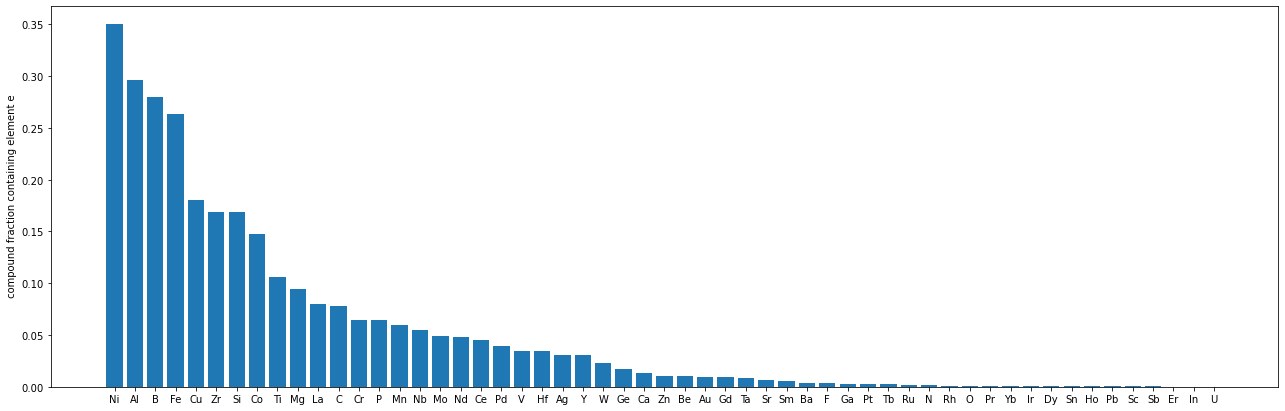

In [7]:
## /!\ the interpretation is different from the steels
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    tot = np.sum(list(s.values()))
    for e in s:
        elements[e] += 1
        proportions[e] += [s[e]/tot]
        
for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w",figsize=(22,7));
#ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel(" compound fraction containing element e");

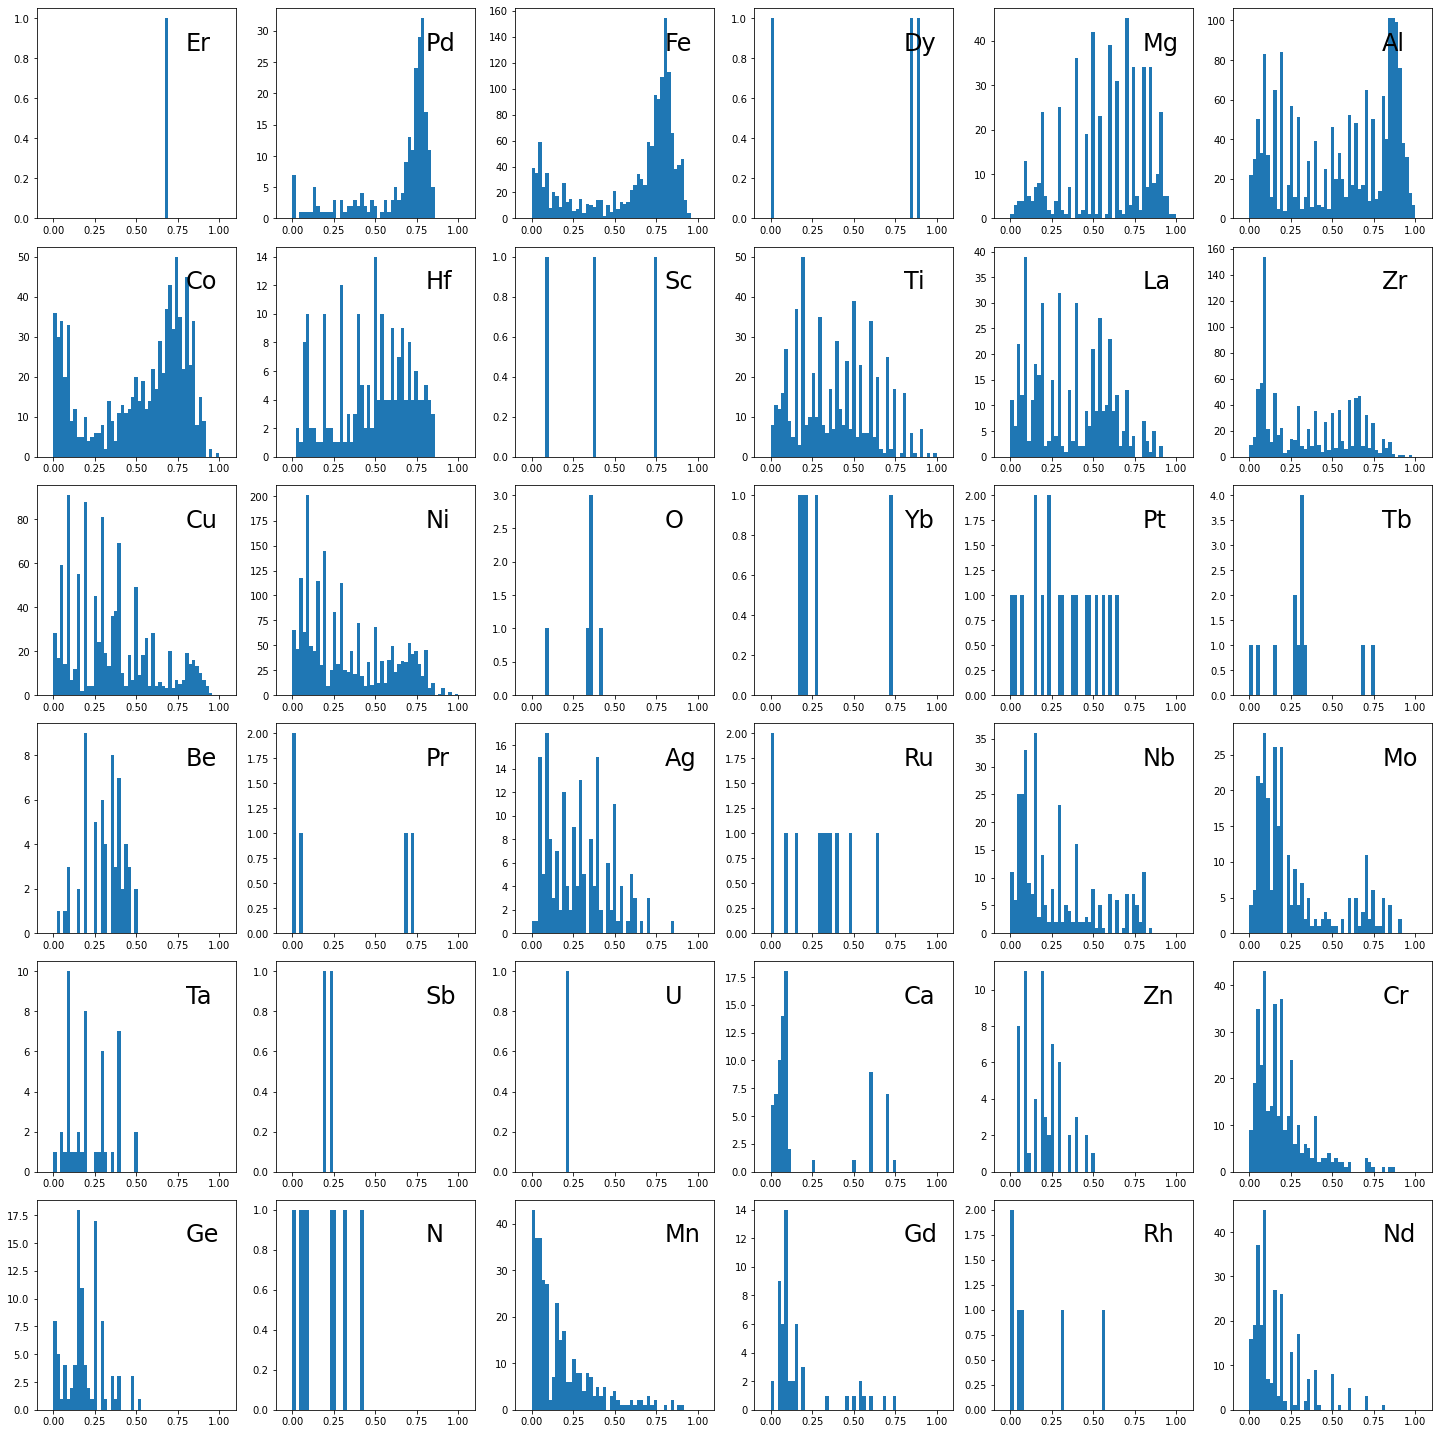

In [8]:
# distribution of element proportions across compositions
fig, axis = plt.subplots(6, 6, facecolor="w", figsize=(20, 20))
for ax, elem in zip(axis.flatten(), mean_proportions):
    ax.hist(
        proportions[elem], 
        bins=np.linspace(0, 1, 50), 
        density=False, 
    )
    ax.set_xlim(-0.1, 1.1)
    ax.text(0.75, 0.8, elem, fontsize=24, transform=ax.transAxes, )
    #ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [9]:
df['gfa'] = df['gfa'].map(int)
df.describe()

,gfa
count,5680.000000
mean,0.710387
std,0.453623
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Text(0.5, 0, 'gfa')

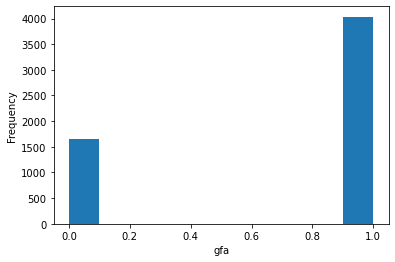

In [10]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["gfa"]);
ax.set_ylabel("Frequency")
ax.set_xlabel("gfa")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [11]:
class CompositionOnlyFeaturizer(MODFeaturizer):
    composition_featurizers = DeBreuck2020Featurizer.composition_featurizers
    
    def featurize_composition(self, df):
        """ Applies the preset composition featurizers to the input dataframe,
        renames some fields and cleans the output dataframe.

        """
        from pymatgen.core.periodic_table import Element 
        import numpy as np
        from modnet.featurizers import clean_df
        df = super().featurize_composition(df)
        _orbitals = {"s": 1, "p": 2, "d": 3, "f": 4}
        df['AtomicOrbitals|HOMO_character'] = df['AtomicOrbitals|HOMO_character'].map(_orbitals)
        df['AtomicOrbitals|LUMO_character'] = df['AtomicOrbitals|LUMO_character'].map(_orbitals)

        df['AtomicOrbitals|HOMO_element'] = df['AtomicOrbitals|HOMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )
        df['AtomicOrbitals|LUMO_element'] = df['AtomicOrbitals|LUMO_element'].apply(
            lambda x: -1 if not isinstance(x, str) else Element(x).Z
        )

        df = df.replace([np.inf, -np.inf, np.nan], 0)
        
        return clean_df(df)

class CompositionContainer:
    def __init__(self, composition):
        self.composition = composition

In [12]:
PRECOMPUTED_MODDATA = "./precomputed/glass_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    #df = load_dataset("matbench_glass")
    #df["composition"] = df["composition"].map(Composition)
    df["structure"] = df["composition"].map(CompositionContainer)
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["gfa"].tolist(), 
        target_names=["gfa"],
        featurizer=CompositionOnlyFeaturizer(n_jobs=8),
        num_classes = {'gfa':2}
    )
    data.featurize()
    # As this is a small data/feature set, order all features 
    data.feature_selection(n=-1)
    data.save(PRECOMPUTED_MODDATA)

INFO:root:Loaded <modnet.preprocessing.MODData object at 0x7ff5c5b01790> object, created with modnet version 0.1.8


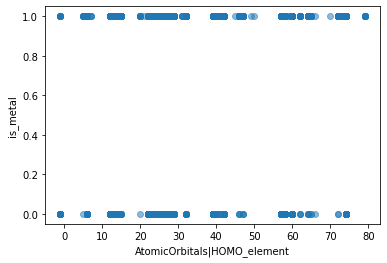

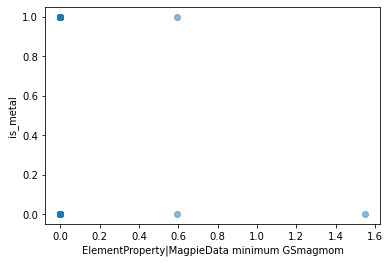

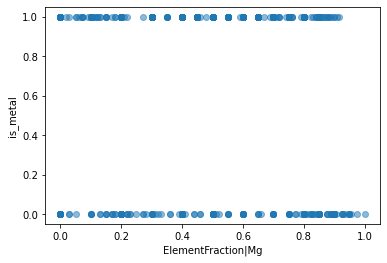

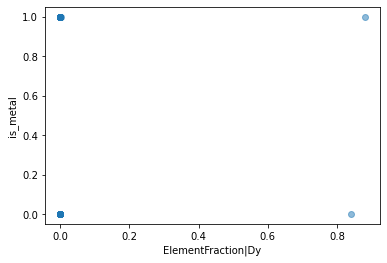

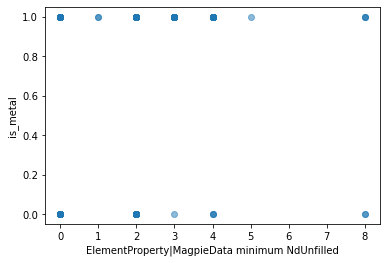

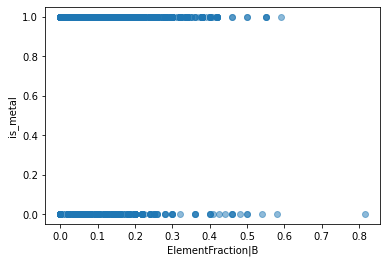

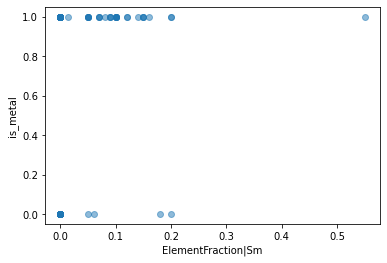

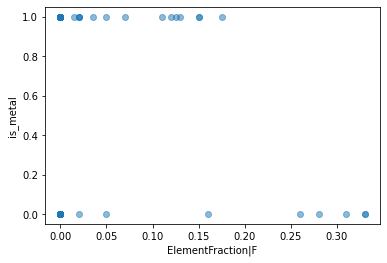

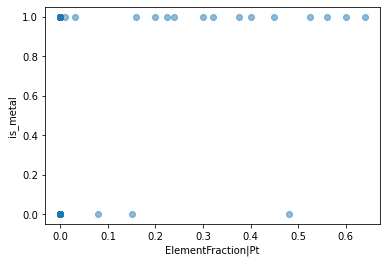

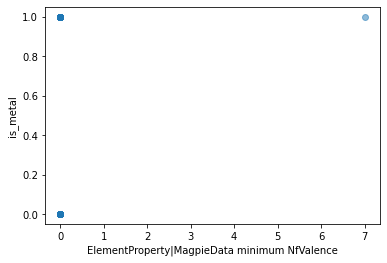

In [13]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("is_metal")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [14]:
try:
    plot_benchmark
except:
    import sys
    sys.path.append('..')
    from modnet_matbench.utils import *

In [16]:
from sklearn.model_selection import KFold
#from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data.df_targets['gfa'] = data.df_targets['gfa'].map(int)

best_settings = {
    "increase_bs":True,
    "num_neurons": [[128], [64], [16], []],
    "n_feat": 150,
    "lr": 0.002,
    "epochs": 200,
    "verbose": 0,
    "act": "elu",
    "batch_size": 64,
    "num_classes": {'gfa':2},
    "loss": "categorical_crossentropy",
    #"xscale": "standard",
}

results = matbench_benchmark(data, [[["gfa"]]], {"gfa": 1}, best_settings,classification=True, save_folds=True)
np.mean(results['scores'])

INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #1: ROC_AUC = 0.9203174638853924


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #2: ROC_AUC = 0.9277644403104424


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #3: ROC_AUC = 0.9262926357736088


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #4: ROC_AUC = 0.9270015098522638


INFO:root:Compiling model...
INFO:root:Fitting model...
INFO:root:Compiling model...
INFO:root:Fitting model...


Model #5: ROC_AUC = 0.9258766810547334


0.9254505461752881

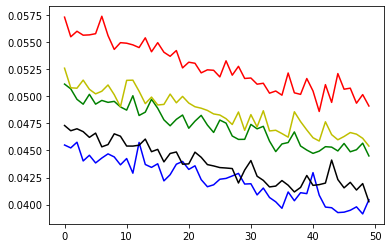

In [18]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    #plt.plot(results["models"][i].history.history["val_loss"][50:],':',c=c)

## Feature selection

In [17]:
model = results['models'][0]

In [18]:
def process(data):
    x = data.get_featurized_df()[model.optimal_descriptors[:model.n_feat]]
    x = model._scaler.transform(x)
    x = np.nan_to_num(x)
    return x

In [19]:
try:
    matbench_kfold_splits()
except:
    os.chdir("..")
    from modnet_matbench.utils import matbench_kfold_splits


In [20]:
import shap
shap.initjs()
for train, test in matbench_kfold_splits(data):
    train_moddata, test_moddata = data.split((train, test))
    break

X_train = shap.sample(process(train_moddata))
explainer = shap.KernelExplainer(model.model.predict, X_train)

In [ ]:
shap_values = explainer.shap_values(X_train, nsamples=1000)

INFO:shap:num_full_subsets = 0
INFO:shap:remaining_weight_vector = [0.18119723 0.09123663 0.0612558  0.04627001 0.03728231 0.03129372
 0.02701898 0.02381544 0.02132609 0.01933672 0.01771101 0.01635808
 0.01521503 0.01423692 0.0133908  0.01265195 0.01200148 0.01142469
 0.01090998 0.01044807 0.01003144 0.00965395 0.00931053 0.00899695
 0.00870965 0.00844563 0.00820234 0.00797759 0.00776948 0.00757638
 0.00739686 0.00722969 0.00707377 0.00692813 0.00679193 0.0066644
 0.00654489 0.00643277 0.00632752 0.00622865 0.00613573 0.00604837
 0.0059662  0.00588891 0.00581621 0.00574783 0.00568353 0.00562309
 0.00556632 0.00551302 0.00546304 0.00541622 0.00537242 0.00533152
 0.0052934  0.00525796 0.00522509 0.00519471 0.00516674 0.00514111
 0.00511776 0.00509662 0.00507764 0.00506078 0.005046   0.00503326
 0.00502252 0.00501378 0.005007   0.00500216 0.00499927 0.0049983 ]
INFO:shap:num_paired_subset_sizes = 71
INFO:shap:weight_left = 1.0
INFO:shap:np.sum(w_aug) = 144.0
INFO:shap:np.sum(self.kernelWe

In [ ]:
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[0], 
    feature_names=model.optimal_descriptors[:model.n_feat], 
    out_names=["is_not_metal"],
)

In [ ]:
shap.summary_plot(shap_values[0], X_train, max_display=32, plot_type="dot", feature_names=model.optimal_descriptors[:model.n_feat])